In [26]:
import random
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import time

In [27]:
# Cargar los nodos del archivo ch150.tsp
nodes = []
with open('ch150.tsp') as file:
  for line in file:
    index, x, y = line.split(" ")
    nodes.append((float(x), float(y)))

In [28]:
# Función para calcular la distancia entre dos nodos
def distance(node1_index, node2_index):
  """
  Los nodos van desde 1 hasta 150
  """
  node1 = nodes[node1_index - 1]
  node2 = nodes[node2_index - 1]
  return ((node1[0] - node2[0])**2 + (node1[1] - node2[1])**2)**0.5

In [29]:
# Función para calcular la distancia total de un recorrido
def total_distance(route):
  """
  El recorrido es una lista con 150 números enteros no repetidos entre 1 y 150
  """
  if len(route) != 150:
    raise ValueError("El recorrido debe tener 150 nodos")
  
  total = 0
  for i in range(len(route) - 1):
    total += distance(route[i], route[i + 1])
  return total

In [30]:
# Realizar el cálculo de la distancia del recorrido óptimo
with open('ch150.opt.tour', 'r') as file:
    opt_route = [int(line.strip()) for line in file]
    
    print(f"Distancia óptima: {total_distance(opt_route)}")

Distancia óptima: 6511.241138358433


In [31]:
# Función para generar una población aleatoria de permutaciones
def generate_population(size):
  population = []
  for _ in range(size):
    individual = list(range(1, 151))
    random.shuffle(individual)
    population.append(individual)
  return population

In [32]:
# Función Partially-mapped crossover (PMX)
def pmx_crossover(parent1, parent2):
    # Seleccionar dos puntos de cruce aleatorios
    size = len(parent1)
    crossover_point1 = random.randint(0, size - 1)
    crossover_point2 = random.randint(crossover_point1 + 1, size)

    # Nueva descendencia vacía
    offspring1 = [None] * size # contiene segmento de parent1 y valores restantes de parent2
    offspring2 = [None] * size # contiene segmento de parent2 y valores restantes de parent1

    # Copiar el segmento entre los puntos de cruce de los padres a los hijos
    offspring1[crossover_point1:crossover_point2] = parent1[crossover_point1:crossover_point2]
    offspring2[crossover_point1:crossover_point2] = parent2[crossover_point1:crossover_point2]

    # Mapear los valores de parent2 a offspring1 y viceversa
    mapping1 = {parent1[i]: parent2[i] for i in range(crossover_point1, crossover_point2)}
    mapping2 = {parent2[i]: parent1[i] for i in range(crossover_point1, crossover_point2)}

    # Rellenar los valores faltantes en offspring1 con valores de parent2
    for i in range(size):
        if offspring1[i] is None:
            value = parent2[i]
            while value in offspring1:
                value = mapping1[value] if value in mapping1 else mapping2[value]
            offspring1[i] = value

    # Rellenar los valores faltantes en offspring2 con valores de parent1
    for i in range(size):
        if offspring2[i] is None:
            value = parent1[i]
            while value in offspring2:
                value = mapping2[value] if value in mapping2 else mapping1[value]
            offspring2[i] = value

    return offspring1, offspring2

In [33]:
def displacement_mutation(tour):

    # Seleccionar aleatoriamente los índices de inicio y fin para el subtour
    start_index = random.randint(0, len(tour) - 2)  # Asegura al menos una ciudad en el subtour
    end_index = random.randint(start_index + 1, len(tour) - 1)  # Asegura que el fin esté después del inicio

    # Extraer el subtour seleccionado
    subtour = tour[start_index:end_index + 1]

    # Remover el subtour del recorrido original
    remaining_tour = tour[:start_index] + tour[end_index + 1:]

    # Seleccionar aleatoriamente una posición en el recorrido restante para insertar el subtour
    if remaining_tour:
        insert_index = random.randint(0, len(remaining_tour))

        # Crear el nuevo recorrido insertando el subtour
        mutated_tour = remaining_tour[:insert_index] + subtour + remaining_tour[insert_index:]

        return mutated_tour
    else:
        # Si el recorrido original era solo un subtour, devuelve el subtour como el nuevo recorrido
        return subtour

In [34]:
def get_survivors(sorted_population, survival_rate):
  
  # Generar probabilidades con un decaimiento logarítmico
  prob = np.logspace(0, -1, len(sorted_population))
  prob /= prob.sum() # normalizar
  
  survivals_num = int(len(sorted_population) * survival_rate)
  
  flat_population = np.array(sorted_population)
    
  # Seleccionar sobrevivientes
  survivals = flat_population[np.random.choice(flat_population.shape[0], size=survivals_num, p=prob, replace=False)]
  
  return survivals.tolist()

In [35]:
def plot_route(route, iteration, best_distance, ax=None, show=True):
    if ax is None:
        _, ax = plt.subplots()
    
    ax.clear()
    x_coords = [nodes[i - 1][0] for i in route]
    y_coords = [nodes[i - 1][1] for i in route]

    ax.plot(x_coords + [x_coords[0]], y_coords + [y_coords[0]], 'bo-', label="Ruta")

    ax.set_title(f"Visualización de Ruta - Iteración: {iteration}, Mejor Distancia: {best_distance:.2f}")
    ax.set_xlabel("Coordenada X")
    ax.set_ylabel("Coordenada Y")
    ax.legend()

    if show:
        plt.draw()


In [36]:
survival_rate = 0.3
crossover_rate = 0.6
mutation_rate = 1 - crossover_rate
population_size = 500
retain_count = int(0.01 * population_size)
timeout = 5400 # segundos

In [37]:
random.seed(1521) # Semilla random
np.random.seed(1521)
population = generate_population(population_size)

generation = 0
best_route = None
best_distance = float('inf')
gen = None
history = [] # (route, distance, generation)

start_time = time.time()

while True:
    # Evaluar la aptitud de la población
    population.sort(key=lambda route: total_distance(route))
    
    best_population_distance = total_distance(population[0])
    if best_population_distance < best_distance:
        best_route = population[0]
        best_distance = best_population_distance
        gen = generation + 1
        
    # Guardar historial de mejor ruta en algunas generaciones
    if (generation < 300 and generation % 25 == 0) or (generation >= 300 and generation % 250 == 0):
        history.append((population[0], best_population_distance, generation + 1))
    
    print(f"Generación {generation + 1} - Mejor distancia: {best_population_distance}", len(population))
    
    # Seleccionar sobrevivientes
    survivors = get_survivors(population, survival_rate)

    # Crear nueva población
    new_population = population[:retain_count]

    # Generar nuevos individuos por cruce
    selected_parents = []
    attempts = 0
    while len(new_population) < population_size * crossover_rate:
        
        if attempts > 50:
            parent1 = random.choice(survivors)
            parent2 = random.choice(survivors)
        else:
        
            # Seleccionar a los padres por torneo
            torney_size = 3
            parent1 = min(random.sample(survivors, torney_size), key=lambda route: total_distance(route))
            parent2 = min(random.sample(survivors, torney_size), key=lambda route: total_distance(route))
            
        if parent1 == parent2:
            attempts += 1
            continue
        
        if (parent1, parent2) in selected_parents or (parent2, parent1) in selected_parents:
            attempts += 1
            continue
        
        attempts = 0
        selected_parents.append((parent1, parent2))
        selected_parents.append((parent2, parent1))
        
        childs = pmx_crossover(parent1, parent2)
        new_population.extend(childs)
        if len(new_population) >= population_size * crossover_rate:
            break

    # Generar nuevos individuos por mutación
    while len(new_population) < population_size:
        individual_to_mutate = random.choice(survivors)
        mutated_individual = displacement_mutation(individual_to_mutate)
        new_population.append(mutated_individual)

    # Mantener la cantidad de la población
    population = new_population[:population_size]
    generation += 1
    
    # Verificar si se ha superado el tiempo límite
    if time.time() - start_time > timeout:
        print(f"Límte de tiempo alcanzado ({timeout} segundos)")
        break

print(f"Generación: {gen}")
print(f"Mejor ruta: {best_route}")
print(f"Distancia total: {best_distance}")

Generación 1 - Mejor distancia: 48454.32195288345 500
Generación 2 - Mejor distancia: 46645.16569156999 500
Generación 3 - Mejor distancia: 46448.93185486518 500
Generación 4 - Mejor distancia: 46329.96078561889 500
Generación 5 - Mejor distancia: 44955.42865252536 500
Generación 6 - Mejor distancia: 44690.25395097293 500
Generación 7 - Mejor distancia: 44690.25395097293 500
Generación 8 - Mejor distancia: 44290.610494803055 500
Generación 9 - Mejor distancia: 42578.57061280094 500
Generación 10 - Mejor distancia: 42495.63754707746 500
Generación 11 - Mejor distancia: 41967.98130692656 500
Generación 12 - Mejor distancia: 41069.11535786087 500
Generación 13 - Mejor distancia: 40460.61480961431 500
Generación 14 - Mejor distancia: 40418.63748874079 500
Generación 15 - Mejor distancia: 39809.23076251532 500
Generación 16 - Mejor distancia: 39336.59918843828 500
Generación 17 - Mejor distancia: 39336.59918843828 500
Generación 18 - Mejor distancia: 38815.07785787326 500
Generación 19 - Me

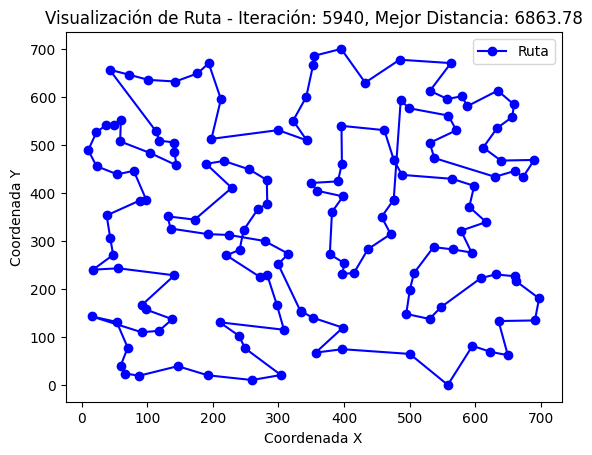

In [42]:
plot_route(best_route, gen, best_distance)


MovieWriter ffmpeg unavailable; using Pillow instead.


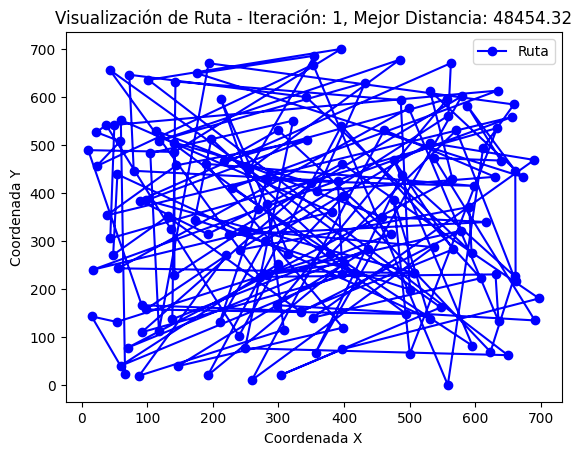

In [43]:
# Configuración para la animación
fig, ax = plt.subplots()
def animate(i):
    route, distance, gen = history[i]
    plot_route(route, gen, distance, ax=ax, show=False)

# Crear animación
ani = FuncAnimation(fig, animate, frames=len(history), repeat=False)

# Guardar la animación como un archivo GIF o MP4
ani.save('ruta_animacion.gif', fps=5)

In [44]:
# semilla 1521 1% de retención, 90 minutos
res = [51, 109, 43, 67, 38, 23, 32, 131, 134, 138, 54, 92, 46, 90, 83, 141, 25, 20, 47, 120, 139, 40, 53, 118, 24, 12, 116, 101, 41, 57, 39, 127, 69, 36, 61, 11, 148, 130, 17, 66, 60, 140, 117, 27, 31, 129, 144, 49, 147, 122, 77, 133, 59, 79, 88, 94, 121, 52, 35, 93, 126, 33, 105, 111, 16, 15, 78, 80, 14, 72, 145, 64, 112, 136, 123, 74, 13, 106, 91, 119, 68, 128, 4, 104, 45, 71, 44, 115, 150, 21, 125, 22, 149, 62, 3, 113, 10, 63, 48, 73, 76, 87, 1, 98, 103, 34, 30, 96, 89, 8, 84, 7, 82, 95, 107, 5, 100, 143, 97, 124, 146, 56, 26, 75, 18, 142, 85, 65, 132, 137, 50, 135, 70, 108, 102, 114, 99, 19, 2, 37, 6, 28, 9, 42, 110, 81, 29, 86, 58, 55]
print(f"Distancia total: {total_distance(res)}")

Distancia total: 6863.777548457688


In [40]:
# semilla 1521, 1% de retención
res = [51, 109, 43, 67, 38, 23, 32, 131, 134, 138, 46, 54, 92, 90, 83, 141, 25, 20, 47, 37, 6, 9, 28, 42, 120, 139, 40, 53, 118, 24, 12, 116, 39, 57, 41, 101, 127, 69, 36, 61, 11, 148, 130, 17, 66, 60, 140, 117, 27, 31, 129, 144, 147, 49, 122, 77, 133, 16, 59, 79, 88, 94, 121, 52, 35, 93, 126, 33, 105, 111, 15, 78, 80, 14, 72, 145, 64, 112, 136, 123, 74, 13, 106, 91, 119, 68, 128, 104, 4, 45, 71, 44, 115, 150, 21, 125, 22, 149, 62, 3, 113, 10, 63, 48, 73, 76, 87, 1, 98, 103, 34, 30, 96, 89, 8, 84, 7, 82, 95, 107, 5, 100, 143, 97, 124, 146, 56, 26, 75, 18, 142, 85, 65, 132, 137, 50, 135, 70, 108, 102, 114, 99, 19, 2, 110, 81, 29, 86, 58, 55]
print(f"Distancia total: {total_distance(res)}")

Distancia total: 6970.564348853048


In [41]:
# semilla 42, 1 solo retención
res = [52, 126, 93, 35, 124, 8, 30, 63, 48, 73, 76, 34, 87, 1, 98, 103, 82, 95, 107, 5, 100, 143, 97, 7, 84, 89, 96, 10, 113, 3, 62, 149, 22, 125, 150, 115, 44, 64, 112, 136, 31, 27, 129, 144, 147, 49, 72, 145, 123, 74, 13, 106, 91, 119, 68, 128, 71, 45, 4, 104, 21, 88, 94, 121, 79, 16, 111, 105, 33, 92, 54, 134, 138, 46, 25, 141, 58, 55, 50, 135, 86, 81, 110, 29, 2, 37, 42, 9, 28, 6, 19, 99, 114, 102, 108, 70, 137, 132, 65, 85, 142, 18, 75, 83, 26, 146, 56, 90, 109, 43, 12, 127, 69, 36, 61, 11, 148, 130, 17, 66, 60, 140, 117, 41, 57, 39, 101, 116, 24, 118, 53, 139, 40, 120, 47, 20, 51, 67, 38, 23, 32, 131, 77, 133, 122, 14, 80, 15, 78, 59]
print(f"Distancia total: {total_distance(res)}")

Distancia total: 7250.760356853727
